# Programmatic approach for severity classes prediction #
Second version of model training notebook where dataset preparation is moved to a separate parametrized function, allowing to try out more different combinations

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

class DatasetPreparer:
    def __init__(self, filepath, delimiter='\t', predict='Depression', use_tipi=False, use_smote=False, impute_mode=False, include_major=False):
        self.filepath = filepath
        self.delimiter = delimiter
        self.predict = predict
        self.use_tipi = use_tipi
        self.use_smote = use_smote
        self.impute_mode = impute_mode
        self.include_major = include_major
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        self.df = pd.read_csv(self.filepath, delimiter=self.delimiter)

    def preprocess_data(self):
        # Calculate DASS scores
        depression_questions = ['Q3A', 'Q5A', 'Q10A', 'Q13A', 'Q16A', 'Q17A', 'Q21A', 'Q24A', 'Q26A', 'Q31A', 'Q34A', 'Q37A', 'Q38A', 'Q42A']
        anxiety_questions = ['Q2A', 'Q4A', 'Q7A', 'Q9A', 'Q15A', 'Q19A', 'Q20A', 'Q23A', 'Q25A', 'Q28A', 'Q30A', 'Q36A', 'Q40A', 'Q41A']
        stress_questions = ['Q1A', 'Q6A', 'Q8A', 'Q11A', 'Q12A', 'Q14A', 'Q18A', 'Q22A', 'Q27A', 'Q29A', 'Q32A', 'Q33A', 'Q35A', 'Q39A']

        # Adjust scores
        self.df[depression_questions] = self.df[depression_questions] - 1
        self.df[anxiety_questions] = self.df[anxiety_questions] - 1
        self.df[stress_questions] = self.df[stress_questions] - 1

        # Calculate the scores for each scale
        self.df['Depression_Score'] = self.df[depression_questions].sum(axis=1)
        self.df['Anxiety_Score'] = self.df[anxiety_questions].sum(axis=1)
        self.df['Stress_Score'] = self.df[stress_questions].sum(axis=1)

        # Categorize severities
        self.df['Depression_Severity'] = self.df['Depression_Score'].apply(self.categorize_depression)
        self.df['Anxiety_Severity'] = self.df['Anxiety_Score'].apply(self.categorize_anxiety)
        self.df['Stress_Severity'] = self.df['Stress_Score'].apply(self.categorize_stress)

       # Select only relevant columns
        demographic_columns = [
            'education', 'urban', 'gender', 'engnat', 'age', 'hand', 'religion',
            'orientation', 'race', 'voted', 'married', 'familysize'
        ]
        if self.include_major:
            demographic_columns.append('major')

        severity_column = f'{self.predict}_Severity'
        selected_columns = demographic_columns + [severity_column]

        if self.use_tipi:
            # Include TIPI questions
            tipi_columns = [col for col in self.df.columns if col.startswith('TIPI')]
            selected_columns += tipi_columns

        self.df = self.df[selected_columns]

        # One-hot encoding
        columns_one_hot_encode = ['urban', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'race', 'voted', 'married']
        if 'major' in columns_one_hot_encode and not self.include_major:
            columns_one_hot_encode.remove('major')

        self.df = pd.get_dummies(self.df, columns=columns_one_hot_encode, drop_first=True)

        if self.impute_mode:
            # Mode imputation
            imputer = SimpleImputer(strategy='most_frequent')
            self.df = pd.DataFrame(imputer.fit_transform(self.df), columns=self.df.columns)


    #Assigning classes based on scored (to be used for prediction)
    def categorize_depression(self, score):
        if score <= 9:
            return 'Normal'
        elif score <= 13:
            return 'Mild'
        elif score <= 20:
            return 'Moderate'
        elif score <= 27:
            return 'Severe'
        else:
            return 'Extremely Severe'

    def categorize_anxiety(self, score):
        if score <= 7:
            return 'Normal'
        elif score <= 9:
            return 'Mild'
        elif score <= 14:
            return 'Moderate'
        elif score <= 19:
            return 'Severe'
        else:
            return 'Extremely Severe'

    def categorize_stress(self, score):
        if score <= 14:
            return 'Normal'
        elif score <= 18:
            return 'Mild'
        elif score <= 25:
            return 'Moderate'
        elif score <= 33:
            return 'Severe'
        else:
            return 'Extremely Severe'

    def encode_target(self):
        le = LabelEncoder()
        target_column = f'{self.predict}_Severity_encoded'
        self.df[target_column] = le.fit_transform(self.df[f'{self.predict}_Severity'])

    def split_data(self):
        X = self.df.drop([f'{self.predict}_Severity', f'{self.predict}_Severity_encoded'], axis=1)
        y = self.df[f'{self.predict}_Severity_encoded']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if self.use_smote:
            smote = SMOTE()
            self.X_train, self.y_train = smote.fit_resample(self.X_train, self.y_train)

    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Predicting depression, using TIPI questions without SMOTE, with mode imputation, without including major

In [ ]:

preparer = DatasetPreparer(
    filepath='/content/drive/My Drive/Data Science/DASS dataset/filtered_data.csv',
    predict='Depression',  # Can be 'anxiety' or 'stress'
    use_tipi=True,         # Include TIPI questions
    use_smote=False,        # Apply SMOTE for balancing
    impute_mode=True,       # Impute missing values with mode
    include_major=False
)

In [ ]:
preparer.load_data()
preparer.preprocess_data()
preparer.encode_target()
preparer.split_data()
X_train, X_test, y_train, y_test = preparer.get_data()

In [ ]:
#Validating training data
X_train.head()

,education,age,familysize,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,...,orientation_5.0,race_20,race_30,race_40,race_50,race_60,race_70,voted_2.0,married_2.0,married_3.0
21160,2.0,19,4.0,5,2,5,7,5,5,5,...,0,0,0,0,0,0,0,1,0,0
37530,2.0,17,3.0,4,4,4,6,4,5,4,...,0,0,0,0,0,0,0,1,0,0
31143,1.0,28,1.0,1,1,1,5,2,1,1,...,0,0,0,0,0,0,1,1,0,0
31817,4.0,28,5.0,5,3,3,4,6,7,5,...,0,0,0,0,0,0,0,0,0,0
18558,4.0,28,3.0,5,3,6,7,4,6,6,...,0,0,0,0,0,0,0,1,0,0


Precictions on 3 models at once (logistic regression, random forest, SVM)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the models
logistic_regression_model = LogisticRegression()
random_forest_model = RandomForestClassifier()
svm_model = SVC()

# Train the models
logistic_regression_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Make predictions
lr_predictions = logistic_regression_model.predict(X_test)
rf_predictions = random_forest_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)

# Calculate accuracies
lr_accuracy = accuracy_score(y_test, lr_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)

# Print accuracies
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"SVM Accuracy: {svm_accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.45
Random Forest Accuracy: 0.46
SVM Accuracy: 0.46


Result: Scores are slightly better than in previous worksheet.

Logistic Regression Accuracy: 0.45
Random Forest Accuracy: 0.46
SVM Accuracy: 0.46

**Without mode imputation. Selected models that can handle NaN values**

In [ ]:

preparer = DatasetPreparer(
    filepath='/content/drive/My Drive/Data Science/DASS dataset/filtered_data.csv',
    predict='Depression',  # Can be 'Anxiety' or 'Stress'
    use_tipi=True,         # Include TIPI questions
    use_smote=False,        # Apply SMOTE for balancing
    impute_mode=False,       # Impute missing values with mode
    include_major=False
)
preparer.load_data()
preparer.preprocess_data()
preparer.encode_target()
preparer.split_data()
X_train, X_test, y_train, y_test = preparer.get_data()

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

hist_gb_model = HistGradientBoostingClassifier()
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier()
cb_model = cb.CatBoostClassifier(verbose=0)  # verbose=0 to avoid too many training details

# Train models
hist_gb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cb_model.fit(X_train, y_train)

# Make predictions
hist_gb_predictions = hist_gb_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
lgb_predictions = lgb_model.predict(X_test)
cb_predictions = cb_model.predict(X_test)

# Calculate accuracy
hist_gb_accuracy = accuracy_score(y_test, hist_gb_predictions)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
lgb_accuracy = accuracy_score(y_test, lgb_predictions)
cb_accuracy = accuracy_score(y_test, cb_predictions)

# Print accuracy scores
print(f"HistGradientBoosting Accuracy: {hist_gb_accuracy:.2f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")
print(f"LightGBM Accuracy: {lgb_accuracy:.2f}")
print(f"CatBoost Accuracy: {cb_accuracy:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 30666, number of used features: 43
[LightGBM] [Info] Start training from score -1.080003
[LightGBM] [Info] Start training from score -2.329220
[LightGBM] [Info] Start training from score -1.718406
[LightGBM] [Info] Start training from score -1.510210
[LightGBM] [Info] Start training from score -1.815118
HistGradientBoosting Accuracy: 0.46
XGBoost Accuracy: 0.45
LightGBM Accuracy: 0.46
CatBoost Accuracy: 0.46


HistGradientBoosting Accuracy: 0.46
XGBoost Accuracy: 0.45
LightGBM Accuracy: 0.46
CatBoost Accuracy: 0.46

Next: Since LightGBM had one of the best results so far with accuracy 0.46, trying out hyperparameter tuning to squeeze even better performance out of the model.

In [ ]:
#LightGBM with hyperparameter tuning
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

lgbm = lgb.LGBMClassifier()
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_lgbm = lgb.LGBMClassifier(**best_params)
best_lgbm.fit(X_train, y_train)
predictions = best_lgbm.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy with best parameters: {accuracy:.2f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 30666, number of used features: 43
[LightGBM] [Info] Start training from score -1.080003
[LightGBM] [Info] Start training from score -2.329220
[LightGBM] [Info] Start training from score -1.718406
[LightGBM] [Info] Start training from score -1.510210
[LightGBM] [Info] Start training from score -1.815118
Best parameters: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

Conclusion: Hyperparameter tuning on LightGBM increased Depression prediction to 0.47

Best parameters: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 30666, number of used features: 43
[LightGBM] [Info] Start training from score -1.955972
[LightGBM] [Info] Start training from score -2.080029
[LightGBM] [Info] Start training from score -1.502709
[LightGBM] [Info] Start training from score -1.221053
[LightGBM] [Info] Start training from score -1.531550


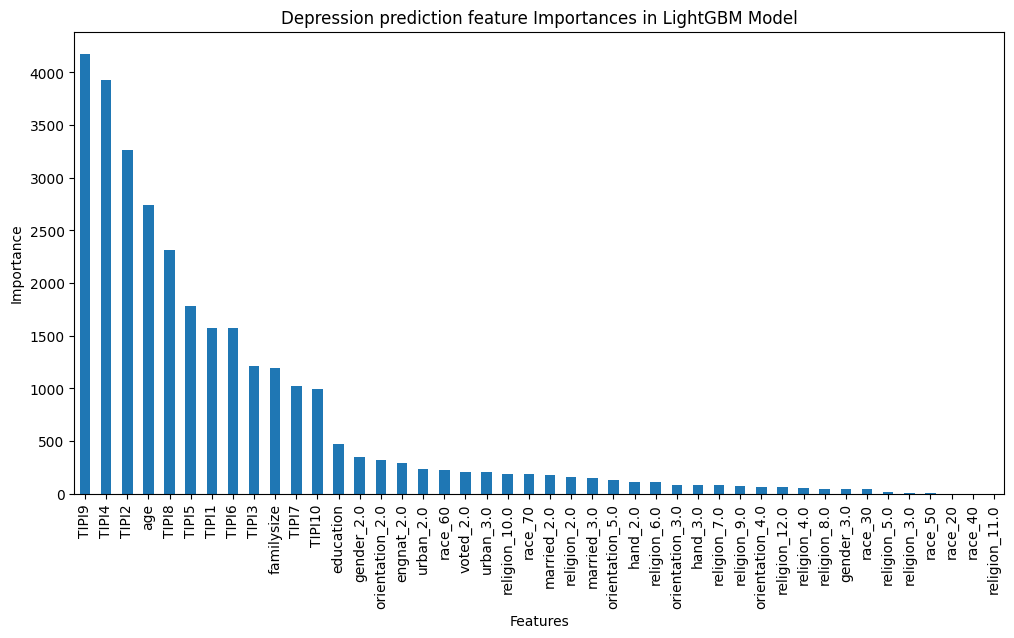

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

params = {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}

# Train the best LightGBM model with the best parameters
best_lgbm = lgb.LGBMClassifier(**params)
best_lgbm.fit(X_train, y_train)

# Get feature importances
feature_importances = best_lgbm.feature_importances_

# Create a pandas Series for easy plotting
feature_names = X_train.columns
feature_importances_series = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sorted_feature_importances.plot(kind='bar')
plt.title('Depression prediction feature Importances in LightGBM Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Next: Since Logistic Regression model is quite fast and with decent results so far, trying out hyperparameter tuning for it also. Using SMOTE dataset wiht mode imputation.

In [ ]:
preparer = DatasetPreparer(
    filepath='/content/drive/My Drive/Data Science/DASS dataset/filtered_data.csv',
    predict='Depression',  # Can be 'anxiety' or 'stress'
    use_tipi=True,         # Include TIPI questions
    use_smote=True,        # Apply SMOTE for balancing
    impute_mode=True,       # Impute missing values with mode
    include_major=False
)
preparer.load_data()
preparer.preprocess_data()
preparer.encode_target()
preparer.split_data()
X_train, X_test, y_train, y_test = preparer.get_data()

In [ ]:
#Logistic regression with hyperparameter tuning
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'solver': ['liblinear', 'saga'],  # Algorithm to use for optimization
    'penalty': ['l1', 'l2']  # Norm used in penalization
}

# Initialize a Logistic Regression model
log_reg = LogisticRegression()

# Initialize the Grid Search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the Logistic Regression model with the best parameters
best_log_reg = LogisticRegression(**best_params)
best_log_reg.fit(X_train, y_train)

# Make predictions
predictions = best_log_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy with best parameters: {accuracy:.2f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Accuracy with best parameters: 0.41


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Conclusion: No major improvement here, LightGBM seems to be the winner

# Anxiety prediction with LightGBM with best parameters #

In [34]:
preparer = DatasetPreparer(
    filepath='/content/drive/My Drive/Data Science/DASS dataset/filtered_data.csv',
    predict='Anxiety',  # Can be 'Anxiety' or 'Stress'
    use_tipi=True,         # Include TIPI questions
    use_smote=False,        # Apply SMOTE for balancing
    impute_mode=False,       # Impute missing values with mode
    include_major=False
)
preparer.load_data()
preparer.preprocess_data()
preparer.encode_target()
preparer.split_data()
X_train, X_test, y_train, y_test = preparer.get_data()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 30666, number of used features: 43
[LightGBM] [Info] Start training from score -1.041204
[LightGBM] [Info] Start training from score -2.651196
[LightGBM] [Info] Start training from score -1.721867
[LightGBM] [Info] Start training from score -1.415075
[LightGBM] [Info] Start training from score -1.865852
Accuracy: 0.49


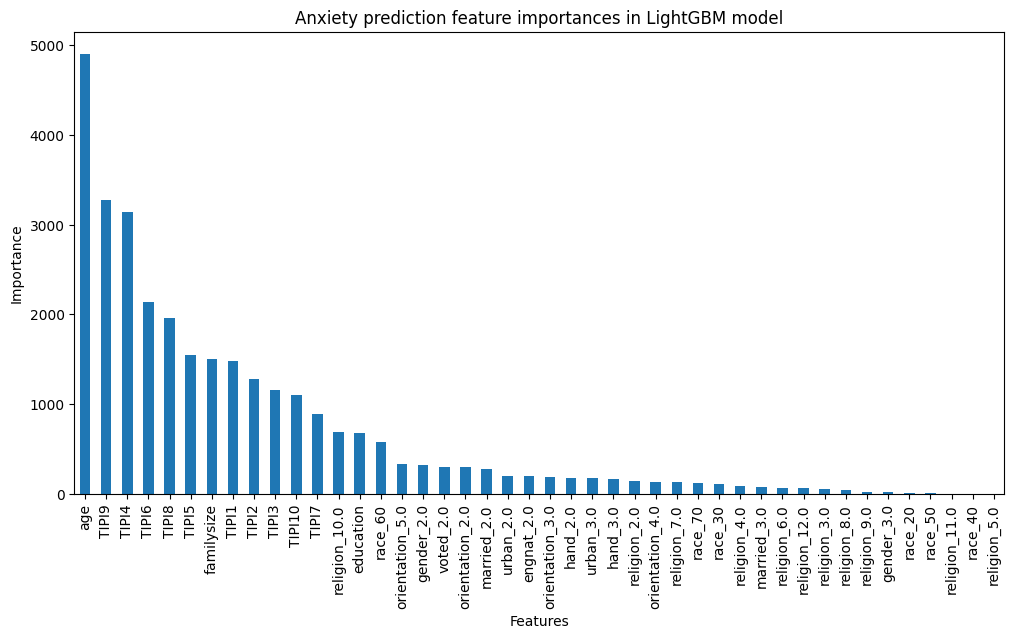

In [35]:
# Set the hyperparameters
params = {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}

# Initialize and train the LightGBM model with the specified parameters
best_lgbm = lgb.LGBMClassifier(**params)
best_lgbm.fit(X_train, y_train)

# Predict on the test set
predictions = best_lgbm.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Get feature importances
feature_importances = best_lgbm.feature_importances_

# Create a pandas Series for easy plotting
feature_names = X_train.columns
feature_importances_series = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
sorted_feature_importances.plot(kind='bar')
plt.title('Anxiety prediction feature importances in LightGBM model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Stress prediction using LightGBM with best parameters

In [ ]:
preparer = DatasetPreparer(
    filepath='/content/drive/My Drive/Data Science/DASS dataset/filtered_data.csv',
    predict='Stress',  # Can be 'Anxiety' or 'Stress'
    use_tipi=True,         # Include TIPI questions
    use_smote=False,        # Apply SMOTE for balancing
    impute_mode=False,       # Impute missing values with mode
    include_major=False
)
preparer.load_data()
preparer.preprocess_data()
preparer.encode_target()
preparer.split_data()
X_train, X_test, y_train, y_test = preparer.get_data()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 30666, number of used features: 43
[LightGBM] [Info] Start training from score -1.955972
[LightGBM] [Info] Start training from score -2.080029
[LightGBM] [Info] Start training from score -1.502709
[LightGBM] [Info] Start training from score -1.221053
[LightGBM] [Info] Start training from score -1.531550
Accuracy: 0.46


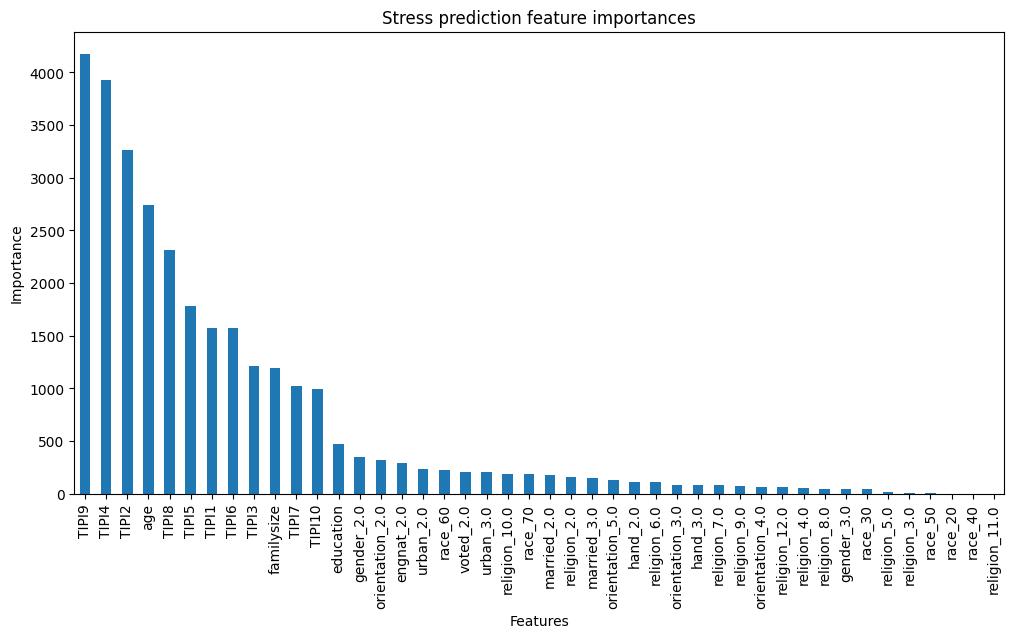

In [ ]:
# Set the hyperparameters
params = {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}

# Initialize and train the LightGBM model with the specified parameters
best_lgbm = lgb.LGBMClassifier(**params)
best_lgbm.fit(X_train, y_train)

# Predict on the test set
predictions = best_lgbm.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Get feature importances
feature_importances = best_lgbm.feature_importances_

# Create a pandas Series for easy plotting
feature_names = X_train.columns
feature_importances_series = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
sorted_feature_importances.plot(kind='bar')
plt.title('Stress prediction feature importances in LightGBM model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

End result: Didn't find any "magic bullet" solution. Switching between different models, different dataset preparations and hyperparameter tuning didn't give significantly better results.

In the LightGBM models with decent accuracies, TIPI questions were the greatest influencers.

Decided with our team to move most of dataset preparation steps to a separate file and write result to a CSV file, so continuing in a new notebook using the latest CSV file that includes most of the preparations.